# 1
Проверить, сбалансирован ли датасет (может быть, наблюдений одного класса слишком много?). Какие результаты покажет dummy classifier, который будет всем новым наблюдениям присваивать класс ham? Насколько плохо такое решение для задачи определения спама?
Грубое решение - включить в training set только необходимое число наблюдений (примерно поровну spam и ham). 

In [24]:
import numpy as np
import pandas
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import classification_report, f1_score
import matplotlib
import seaborn as sns
matplotlib.style.use('ggplot')

In [25]:
path = 'smsspamcollection/SMSSpamCollection'

messages = pandas.read_csv(path, sep='\t',
                           names=["label", "message"])
print(messages.head())
print(messages.groupby('label').describe())

  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
                                                        message
label                                                          
ham   count                                                4825
      unique                                               4516
      top                                Sorry, I'll call later
      freq                                                   30
spam  count                                                 747
      unique                                                653
      top     Please call our customer service representativ...
      freq                                                    4


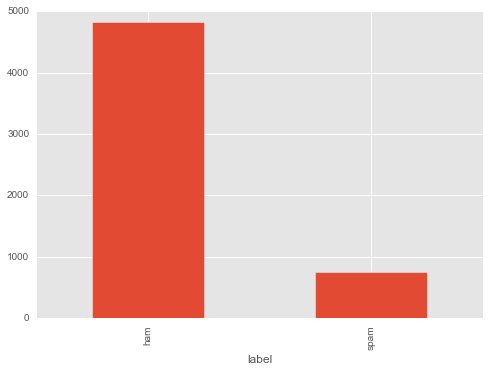

In [26]:
messages.groupby('label').size().plot(kind='bar')
plt.show()

Сообщений, размеченных как спам, 747 – гораздо меньше, чем неспамовых сообщений. Соотношение в выборке - 747/4825, то есть спама всего 15,5%. Выборка не сбалансирована. Самый простой классификатор, который все сообщения будет тправлять в неспам, покажет точность = 4825 / (747 + 4825) = 87%. У меня ни один классификатор, кажется, такую хорошую точность не показывал. Полнота с точки зрения спама при этом будет 0, то есть спам не будет выявляться вообще. Такой классификатор бесполезен.

Сбалансируем выборку. Наберем в новый датасет по 747 спама и хама.

In [27]:
import sklearn.utils


spam = messages.loc[messages['label']=='spam']
ham = messages.loc[messages['label']=='ham'][:747]
df = sklearn.utils.shuffle(spam.append(ham))
print(df.head())
print(df.describe())

     label                                            message
5079  spam  Do you want a New Nokia 3510i colour phone Del...
625    ham  Nah it's straight, if you can just bring bud o...
257    ham        Mmm so yummy babe ... Nice jolt to the suzy
579   spam  our mobile number has won £5000, to claim call...
1137  spam  Dont forget you can place as many FREE Request...
       label                 message
count   1494                    1494
unique     2                    1383
top      ham  Sorry, I'll call later
freq     747                       6


Нормализовать тексты и обучить байесовскую модель (bag of words).

### 1 Разная токенизация – со знаками препинания и без
По дефолту в CountVectorizer нет лемматизации и все знаки препинания считаются сепараторами. 

In [28]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split


bow_1 = CountVectorizer()
bowed_messages_1 = bow_1.fit_transform(df['message'])

naive_1 = MultinomialNB()
y_pred_1 = cross_val_predict(naive_1, bowed_messages_1, df['label'], cv=10)
print(confusion_matrix(y_pred_1, df['label']))
print(classification_report(y_pred_1, df['label']))

[[729  42]
 [ 18 705]]
             precision    recall  f1-score   support

        ham       0.98      0.95      0.96       771
       spam       0.94      0.98      0.96       723

avg / total       0.96      0.96      0.96      1494



Ваще супер. TP = 705, FP = 42.
Теперь пропишем векторайзер, где токенами может быть всякая пунктуация.

In [29]:
bow_2 = CountVectorizer(token_pattern='[\w]+|[\.,\?!\'\"\-\(\);:$]')
bowed_messages_2 = bow_2.fit_transform(df['message'])

naive_2 = MultinomialNB()
y_pred_2 = cross_val_predict(naive_2, bowed_messages_2, df['label'], cv=10)
print(confusion_matrix(y_pred_2, df['label']))
print(classification_report(y_pred_2, df['label']))

[[733  36]
 [ 14 711]]
             precision    recall  f1-score   support

        ham       0.98      0.95      0.97       769
       spam       0.95      0.98      0.97       725

avg / total       0.97      0.97      0.97      1494



Практически то же самое. На 1 выросли TP (706), на 1 снизились FP (41). 
### 2 Разная лемматизация – отсутствие, стемминг, лемматизация
Отсутствие лемматизации мы уже видели. Сделаем стемминг.

In [30]:
from nltk.stem.porter import *
from nltk import word_tokenize


def stemmer_w_punct(text):
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in word_tokenize(text)]
    
    
bow_3 = CountVectorizer(tokenizer=stemmer_w_punct)
bowed_messages_3 = bow_3.fit_transform(df['message'])

naive_3 = MultinomialNB()
y_pred_3 = cross_val_predict(naive_3, bowed_messages_3, df['label'], cv=10)
print(confusion_matrix(y_pred_3, df['label']))
print(classification_report(y_pred_3, df['label']))

[[727  46]
 [ 20 701]]
             precision    recall  f1-score   support

        ham       0.97      0.94      0.96       773
       spam       0.94      0.97      0.96       721

avg / total       0.96      0.96      0.96      1494



Качество ухудшилось, но немного. TP = 701 (-5), FP = 46 (+5).

И стемминг без пунктуации:

In [31]:
import re


RE_WORD = re.compile('[\w]+')


def stemmer_wo_punct(text):
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in RE_WORD.findall(text)]
    
    
bow_4 = CountVectorizer(tokenizer=stemmer_wo_punct)
bowed_messages_4 = bow_4.fit_transform(df['message'])

naive_4 = MultinomialNB()
y_pred_4 = cross_val_predict(naive_4, bowed_messages_4, df['label'], cv=10)
print(confusion_matrix(y_pred_4, df['label']))
print(classification_report(y_pred_4, df['label']))

[[737  37]
 [ 10 710]]
             precision    recall  f1-score   support

        ham       0.99      0.95      0.97       774
       spam       0.95      0.99      0.97       720

avg / total       0.97      0.97      0.97      1494



Стало немного лучше по всем параметрам. TP = 711 (+10), FP = 36 (-10).

Теперь лемматизация с и без пунктуации.

In [32]:
from nltk.stem import WordNetLemmatizer 


def lemmer_w_punct(text):
    return [WordNetLemmatizer().lemmatize(word) for word in word_tokenize(text)]
    
    
bow_5 = CountVectorizer(tokenizer=lemmer_w_punct)
bowed_messages_5 = bow_5.fit_transform(df['message'])

naive_5 = MultinomialNB()
y_pred_5 = cross_val_predict(naive_5, bowed_messages_5, df['label'], cv=10)
print(confusion_matrix(y_pred_5, df['label']))
print(classification_report(y_pred_5, df['label']))

[[727  49]
 [ 20 698]]
             precision    recall  f1-score   support

        ham       0.97      0.94      0.95       776
       spam       0.93      0.97      0.95       718

avg / total       0.95      0.95      0.95      1494



Хуже. TP = 699 (-12), FP = 48 (+12).

In [33]:
from nltk.stem import WordNetLemmatizer


def lemmer_wo_punct(text):
    stemmer = PorterStemmer()
    return [WordNetLemmatizer().lemmatize(word) for word in RE_WORD.findall(text)]
    
    
bow_6 = CountVectorizer(tokenizer=lemmer_wo_punct)
bowed_messages_6= bow_6.fit_transform(df['message'])

naive_6 = MultinomialNB()
y_pred_6 = cross_val_predict(naive_6, bowed_messages_6, df['label'], cv=10)
print(confusion_matrix(y_pred_6, df['label']))
print(classification_report(y_pred_6, df['label']))

[[735  36]
 [ 12 711]]
             precision    recall  f1-score   support

        ham       0.98      0.95      0.97       771
       spam       0.95      0.98      0.97       723

avg / total       0.97      0.97      0.97      1494



Немного лучше. TP = 707 (+8), FP = 40 (-8).
### 3 Удаление стоп-слов и пороги min_df/max_df
Для дальнейшей работы возьмем дефолтную модель и лучший на данный момент вариант – стемминг без пунктуации.

Стоп-слова в дефолтной модели:

In [34]:
bow_7 = CountVectorizer(stop_words='english')
bowed_messages_7 = bow_7.fit_transform(df['message'])

naive_7 = MultinomialNB()
y_pred_7 = cross_val_predict(naive_7, bowed_messages_7, df['label'], cv=10)
print(confusion_matrix(y_pred_7, df['label']))
print(classification_report(y_pred_7, df['label']))

[[713  40]
 [ 34 707]]
             precision    recall  f1-score   support

        ham       0.95      0.95      0.95       753
       spam       0.95      0.95      0.95       741

avg / total       0.95      0.95      0.95      1494



Стоп-слова со стеммингом без пунктуации:

In [35]:
bow_8 = CountVectorizer(tokenizer=stemmer_wo_punct, stop_words='english')
bowed_messages_8 = bow_8.fit_transform(df['message'])

naive_8 = MultinomialNB()
y_pred_8 = cross_val_predict(naive_8, bowed_messages_8, df['label'], cv=10)
print(confusion_matrix(y_pred_8, df['label']))
print(classification_report(y_pred_8, df['label']))

[[723  34]
 [ 24 713]]
             precision    recall  f1-score   support

        ham       0.97      0.96      0.96       757
       spam       0.95      0.97      0.96       737

avg / total       0.96      0.96      0.96      1494



Здесь самые лучшие показатели TP и FP.

Пороги в дефолтной модели:

In [53]:
bow_9 = CountVectorizer(min_df=0.10, max_df=0.90)
bowed_messages_9 = bow_9.fit_transform(df['message'])

naive_9 = MultinomialNB()
y_pred_9 = cross_val_predict(naive_9, bowed_messages_9, df['label'], cv=10)
print(confusion_matrix(y_pred_9, df['label']))
print(classification_report(y_pred_9, df['label']))

[[588 162]
 [159 585]]
             precision    recall  f1-score   support

        ham       0.79      0.78      0.79       750
       spam       0.78      0.79      0.78       744

avg / total       0.79      0.79      0.79      1494



Пороги со стеммингом без пунктуации:

In [55]:
bow_10 = CountVectorizer(tokenizer=stemmer_wo_punct, min_df=0.10, max_df=0.90)
bowed_messages_10 = bow_10.fit_transform(df['message'])

naive_10 = MultinomialNB()
y_pred_10 = cross_val_predict(naive_10, bowed_messages_10, df['label'], cv=10)
print(confusion_matrix(y_pred_10, df['label']))
print(classification_report(y_pred_10, df['label']))

[[611 102]
 [136 645]]
             precision    recall  f1-score   support

        ham       0.82      0.86      0.84       713
       spam       0.86      0.83      0.84       781

avg / total       0.84      0.84      0.84      1494



С порогами все гораздо хуже (хотя можно подбирать параметры, конечно). TP спускается до 598-647, FP поднимается до 100-158. 

### 4 CountVectorizer vs. TfIdfVectorizer
TfIdfVectorizer для дефолтной модели:

In [57]:
bow_11 = TfidfVectorizer()
bowed_messages_11 = bow_11.fit_transform(df['message'])

naive_11 = MultinomialNB()
y_pred_11 = cross_val_predict(naive_11, bowed_messages_11, df['label'], cv=10)
print(confusion_matrix(y_pred_11, df['label']))
print(classification_report(y_pred_11, df['label']))

[[724  43]
 [ 23 704]]
             precision    recall  f1-score   support

        ham       0.97      0.94      0.96       767
       spam       0.94      0.97      0.96       727

avg / total       0.96      0.96      0.96      1494



TfidfVectorizer со стоп-словами и стеммингом без пунктуации:

In [59]:
bow_12 = TfidfVectorizer(tokenizer=stemmer_wo_punct, stop_words='english')
bowed_messages_12 = bow_12.fit_transform(df['message'])

naive_12 = MultinomialNB()
y_pred_12 = cross_val_predict(naive_12, bowed_messages_12, df['label'], cv=10)
print(confusion_matrix(y_pred_12, df['label']))
print(classification_report(y_pred_12, df['label']))

[[712  29]
 [ 35 718]]
             precision    recall  f1-score   support

        ham       0.95      0.96      0.96       741
       spam       0.96      0.95      0.96       753

avg / total       0.96      0.96      0.96      1494



### 5 Что-нибудь ещё? Посмотрим биграммы
Биграммы для дефолтной модели:

In [61]:
bow_13 = CountVectorizer(ngram_range=(2, 2))
bowed_messages_13 = bow_13.fit_transform(df['message'])

naive_13 = MultinomialNB()
y_pred_13 = cross_val_predict(naive_13, bowed_messages_13, df['label'], cv=10)
print(confusion_matrix(y_pred_13, df['label']))
print(classification_report(y_pred_13, df['label']))

[[735 107]
 [ 12 640]]
             precision    recall  f1-score   support

        ham       0.98      0.87      0.93       842
       spam       0.86      0.98      0.91       652

avg / total       0.93      0.92      0.92      1494



Биграммы со стеммингом без пунктуации:

In [64]:
bow_14 = CountVectorizer(tokenizer=stemmer_wo_punct, ngram_range=(2, 2))
bowed_messages_14 = bow_14.fit_transform(df['message'])

naive_14 = MultinomialNB()
y_pred_14 = cross_val_predict(naive_14, bowed_messages_14, df['label'], cv=10)
print(confusion_matrix(y_pred_14, df['label']))
print(classification_report(y_pred_14, df['label']))

[[735  99]
 [ 12 648]]
             precision    recall  f1-score   support

        ham       0.98      0.88      0.93       834
       spam       0.87      0.98      0.92       660

avg / total       0.93      0.93      0.93      1494



С биграммами лучше не стало.

In [65]:
pred = [y_pred_1, y_pred_2, y_pred_3, y_pred_4, y_pred_5, y_pred_6, y_pred_7,
        y_pred_8, y_pred_9, y_pred_10, y_pred_11, y_pred_12, y_pred_13, y_pred_14]

table = pandas.DataFrame(columns=['model', 'TP', 'FP', 'F1'])
for p in range(len(pred)):
    table.loc[len(table)]=[p + 1,
                           confusion_matrix(pred[p], df['label'])[1, 1],
                           confusion_matrix(pred[p], df['label'])[0, 1],
                           classification_report(pred[p], df['label']).split('\n')[5].split()[3]]
table

,model,TP,FP,F1
0,1.0,705.0,42.0,0.96
1,2.0,711.0,36.0,0.97
2,3.0,701.0,46.0,0.96
3,4.0,710.0,37.0,0.97
4,5.0,698.0,49.0,0.95
5,6.0,711.0,36.0,0.97
6,7.0,707.0,40.0,0.95
7,8.0,713.0,34.0,0.96
8,9.0,585.0,162.0,0.79
9,10.0,645.0,102.0,0.84


Если мы смотрим на TP/FP, то лучшая модель – 12, TfidfVectorizer со стоп-словами и стеммингом без пунктуации. Если на F-меру, то можно выбирать любую модель с показателем 97% – 2 (дефолт с пунктуацией), 4 (стемминг без пунктуации), 6 (лемматизация без пунктуации). 

### Extra
Ограничив количество наблюдений ham в обучающей выборке, мы игнорируем довольно много данных. 1) В цикле: случайно выбрать нужное число писем ham и сконструировать сбалансированную выборку, построить классификатор, оценить и записать результат; в итоге результаты усреднить. 2) поможет ли параметр class prior probability?

Перемешаем еще раз весь хам, а потом будем брать по 804 элемента для каждой выборки. Таким образом получим шесть выборок хама. Маленькие выборки чуть-чуть больше спама, но наверное, ничего страшного.

In [74]:
# модель с uniform prior
bow_15 = TfidfVectorizer(tokenizer=stemmer_wo_punct, stop_words='english')
bowed_messages_15 = bow_15.fit_transform(df['message'])
naive_15 = MultinomialNB(fit_prior=False)

ham = messages.loc[messages['label']=='ham']
ham = sklearn.utils.shuffle(spam.append(ham))
j = 0
scores, scores_uni = [], []
for i in range(6):
    spam = messages.loc[messages['label']=='spam']
    new_ham = ham[j:j+804]
    df = sklearn.utils.shuffle(spam.append(new_ham))
    j += 804
    bowed_messages_12 = bow_12.fit_transform(df['message'])
    y_pred_12 = cross_val_predict(naive_12, bowed_messages_12, df['label'], cv=10)
    score = f1_score(df['label'], y_pred_12, pos_label='spam')
    print('Sample {}: f1 = {}'.format(i, score))
    scores.append(score)
    
    # uniform prior
    y_pred_15 = cross_val_predict(naive_15, bowed_messages_15, df['label'], cv=10)
    score_uni = f1_score(df['label'], y_pred_15, pos_label='spam')
    print('Sample {}, uniform prior: f1 = {}'.format(i, score_uni))
    scores_uni.append(score_uni)

np.mean(scores), np.mean(scores_uni)

Sample 0: f1 = 0.9570692615912993
Sample 0, uniform prior: f1 = 0.5208085612366231
Sample 1: f1 = 0.9628339140534263
Sample 1, uniform prior: f1 = 0.538860103626943
Sample 2: f1 = 0.9551208285385501
Sample 2, uniform prior: f1 = 0.5374347069065583
Sample 3: f1 = 0.9568717653824036
Sample 3, uniform prior: f1 = 0.5791855203619909
Sample 4: f1 = 0.9616279069767442
Sample 4, uniform prior: f1 = 0.5266272189349112
Sample 5: f1 = 0.9556706966033393
Sample 5, uniform prior: f1 = 0.5697606538237011


(0.9581990621909604, 0.54544612748178789)

Средняя на всей выборке ожидаемая. Uniform prior, т. е. равномерная class prior probability, не помогает.

# 2
Сравнить результаты байесовского классификатора, решающего дерева и RandomForest. Помимо стандартных метрик оценки качества модели, необходимо построить learning curve, ROC-curve, classification report и интерпретировать эти результаты.

### Decision Tree

In [78]:
bow_16 = CountVectorizer(tokenizer=stemmer_wo_punct, ngram_range=(2, 2))
bowed_messages_16 = bow_16.fit_transform(df['message'])

tree = DecisionTreeClassifier()
y_pred_16 = cross_val_predict(tree, bowed_messages_16, df['label'], cv=10)
print(confusion_matrix(y_pred_16, df['label']))
print(classification_report(y_pred_16, df['label']))

[[674 103]
 [ 24 750]]
             precision    recall  f1-score   support

        ham       0.97      0.87      0.91       777
       spam       0.88      0.97      0.92       774

avg / total       0.92      0.92      0.92      1551



Дерево решений хуже: F-мера = только 92%.

### Random Forest

In [80]:
bow_17 = CountVectorizer(tokenizer=stemmer_wo_punct, ngram_range=(2, 2))
bowed_messages_17 = bow_17.fit_transform(df['message'])

forest = RandomForestClassifier()
y_pred_17 = cross_val_predict(forest, bowed_messages_17, df['label'], cv=10)
print(confusion_matrix(y_pred_17, df['label']))
print(classification_report(y_pred_17, df['label']))

[[691 146]
 [  7 707]]
             precision    recall  f1-score   support

        ham       0.99      0.83      0.90       837
       spam       0.83      0.99      0.90       714

avg / total       0.92      0.90      0.90      1551



И лес тоже хуже.
### Learning curves

Automatically created module for IPython interactive environment


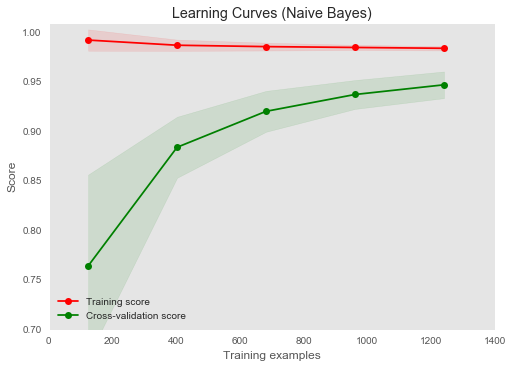

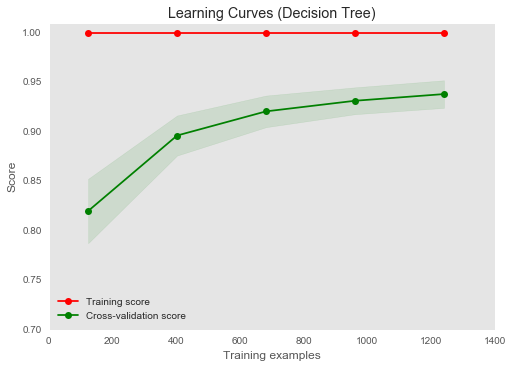

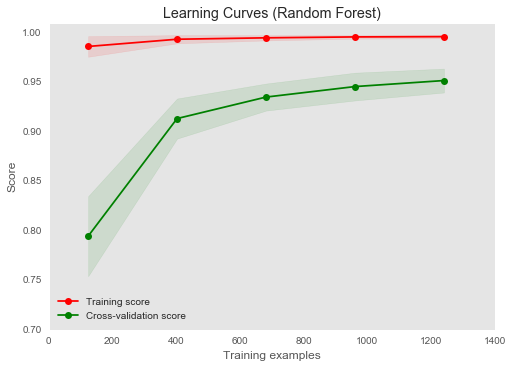

In [87]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

X, y = bowed_messages_12, df['label']

plt.figure()

title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
plot_learning_curve(naive_12, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

title = "Learning Curves (Decision Tree)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
plot_learning_curve(tree, title, X, y, (0.7, 1.01), cv=cv, n_jobs=4)

title = "Learning Curves (Random Forest)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
plot_learning_curve(forest, title, X, y, (0.7, 1.01), cv=cv, n_jobs=4)

plt.show()

Ни одна из кривых не сходится к низкому значению, значит, вроде бы, можно увеличивать количество тренировочных выборок.
### ROC-curves - не работает и сил больше нет
Naive Bayes:

In [139]:
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold


# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)

X, y = bowed_messages_12, df['label']

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
lw = 2

i = 0
for (train, test), color in zip(cv.split(X, y), colors):
    naive_12.fit(X[train], y[train])
    probas_ = naive_12.predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= cv.get_n_splits(X, y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

ValueError: cannot reindex from a duplicate axis

In [149]:
for a, b in cv.split(X, y):
    print(a.shape)

print(X.shape)
print(len(y))

(1291,)
(1292,)
(1293,)
(1293,)
(1293,)
(1293,)
(1551, 3842)
1551


# 3
А что, если в качестве предикторов брать не количество вхождений слов, а конструировать специальные признаки? Прежде всего, необходимо разделить таблицу на training set и test set в соотношении 80:20, test set не открывать до этапа оценки модели. С помощью pandas проверить, отличаются ли перечисленные ниже параметры (иможно придумать другие) для разных классов (spam/ham), и собрать матрицу признаков для обучения. Примеры признаков: длина сообщения, количество букв в ВЕРХНЕМ РЕГИСТРЕ, восклицательных знаков, цифр, запятых, каких-то конкретных слов (для этого можно построить частотный словарь по сообщениям каждого класса). Прокомментировать свой выбор. Векторизовать документы и построить классификатор. Оценить модель на проверочной выборке.

In [116]:
RE_UPPER = re.compile('[A-Z]')
RE_EXCL = re.compile('!')
RE_NUMBER = re.compile('[0-9]')
RE_COMMA = re.compile(',')
RE_BUY = re.compile('[Bb]uy')


length = [len(message) for message in df['message']]
upper = [len(RE_UPPER.findall(message)) for message in df['message']]
exclaim = [len(RE_EXCL.findall(message)) for message in df['message']]
number = [len(RE_NUMBER.findall(message)) for message in df['message']]
comma = [len(RE_COMMA.findall(message)) for message in df['message']]
buy = [len(RE_BUY.findall(message)) for message in df['message']]

new_df = pandas.DataFrame(columns=['length', 'upper', 'exclaim', 'number', 'comma', 'buy', 'label'])
new_df['length'], new_df['upper'], new_df['exclaim'] = length, upper, exclaim
new_df['number'], new_df['comma'], new_df['buy'] = number, comma, buy
new_df['label'] = df['label'].tolist()
new_df[:10]

,length,upper,exclaim,number,comma,buy,label
0,129,7,0,0,0,0,ham
1,33,1,0,0,0,1,ham
2,150,31,0,23,0,0,spam
3,60,3,0,0,0,0,ham
4,173,8,0,33,1,0,spam
5,159,107,2,6,3,0,ham
6,136,14,1,8,0,0,spam
7,159,13,0,26,1,0,spam
8,63,3,0,0,0,0,ham
9,24,1,0,0,0,0,ham


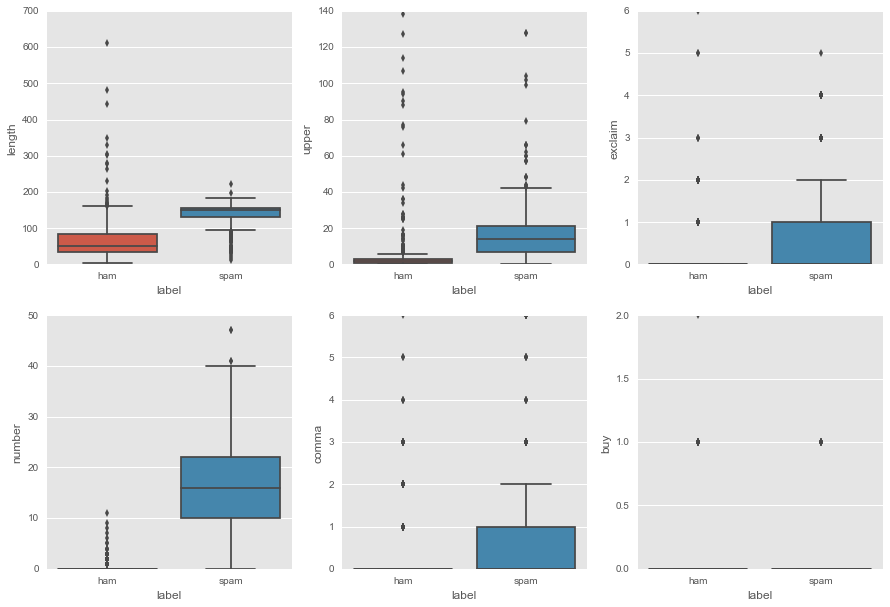

In [133]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
matplotlib.style.use('ggplot')

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.subplot(2,3,1)
sns.boxplot(x='label', y='length', data=new_df)
plt.subplot(2,3,2)
sns.boxplot(x='label', y='upper', data=new_df)
plt.subplot(2,3,3)
sns.boxplot(x='label', y='exclaim', data=new_df)
plt.subplot(2,3,4)
sns.boxplot(x='label', y='number', data=new_df)
plt.subplot(2,3,5)
sns.boxplot(x='label', y='comma', data=new_df)
plt.subplot(2,3,6)
sns.boxplot(x='label', y='buy', data=new_df)
plt.show()

Нуууу дааа, спам в среднем длиннее, в нем больше капса, восклицательных знаков, цифр и запятых. Слово 'buy' встречается редко :(

Построим для этих данных Logit.

In [138]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score


logit = LogisticRegression(class_weight='balanced')
y_pred_new = cross_val_predict(logit, new_df[['length', 'upper', 'exclaim', 'number', 'comma', 'buy']],
                               new_df['label'], cv=10)
print(confusion_matrix(y_pred_new, new_df['label']))
print(classification_report(y_pred_new, new_df['label']))

[[676  83]
 [ 22 770]]
             precision    recall  f1-score   support

        ham       0.97      0.89      0.93       759
       spam       0.90      0.97      0.94       792

avg / total       0.93      0.93      0.93      1551



А неплохо работает. Но все равно хуже наших прошлых моделей.